### Import

In [1]:
from __future__ import print_function



import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import sparse
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Create Graph

In [2]:
num_graphs=20000
G = ['G'+str(i) for i in range(num_graphs)]

for i in range(num_graphs):
    G[i] = nx.dense_gnm_random_graph(100, 200, seed=i)

### Compute Shortest Path Length

In [3]:
path_len = []
for i in range(num_graphs):
    try:
        path_len.append(nx.shortest_path_length(G[i],source=0,target=99))
    except:
        path_len.append(0)

In [4]:
adj1=np.zeros((num_graphs,10000))
for i in range(0,num_graphs):
    adj2 = nx.to_numpy_matrix(G[i])
    adj3 = adj2.tolist()
    merged = []
    for j in adj3:
        merged = merged + j
        adj4=np.asarray(merged)
    #print(len(adj4),type(adj4))
    adj1[i]=adj4
print(adj1.shape,type(adj1))



(20000, 10000) <class 'numpy.ndarray'>


In [5]:
# train/CV/test split
Train = adj1[:16000]
Validation = adj1[6000:8000]
Test = adj1[16000:]

Train_path = np.asarray(path_len[:16000])
Validation_path = np.asarray(path_len[6000:8000])
Test_path = np.asarray(path_len[16000:])


In [6]:
np.amax(path_len)

8

In [7]:
print('a',nx.shortest_path_length(G[99],source=0,target=99))
print('b',Train_path[99])

a 2
b 2


### Set the parameters

In [9]:
learning_rate = 0.01
num_steps = 800
batch_size = 128

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 2nd layer number of neurons
num_input = 10000 # MNIST data input (img shape: 28*28)
num_classes = 9 # MNIST total classes (0-9 digits)

#print(type(mnist.test.images),mnist.test.images.shape,mnist.test.images[0])
#print(type(mnist.test.labels),mnist.test.labels.shape,mnist.test.labels)

### Define the Input Function for Training

In [10]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Train}, y=Train_path,
    batch_size=batch_size, num_epochs=None, shuffle=True)

### Define the Neural Network

In [11]:
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 128 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 128 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    layer_3 = tf.layers.dense(layer_2, n_hidden_3)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_3, num_classes)
    return out_layer

### Define the model function

In [12]:
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

### Build the Estimator

In [13]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\dknif\\AppData\\Local\\Temp\\tmpfb9m89jt', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


### Train the Model

In [14]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dknif\AppData\Local\Temp\tmpfb9m89jt\model.ckpt.
INFO:tensorflow:loss = 2.2711064088, step = 1
INFO:tensorflow:global_step/sec: 21.7831
INFO:tensorflow:loss = 1.69631333934, step = 101 (4.592 sec)
INFO:tensorflow:global_step/sec: 21.499
INFO:tensorflow:loss = 1.40622019015, step = 201 (4.651 sec)
INFO:tensorflow:global_step/sec: 21.4745
INFO:tensorflow:loss = 1.59549918777, step = 301 (4.657 sec)
INFO:tensorflow:global_step/sec: 21.2041
INFO:tensorflow:loss = 1.46658012648, step = 401 (4.716 sec)
INFO:tensorflow:global_step/sec: 21.0099
INFO:tensorflow:loss = 1.35198129295, step = 501 (4.760 sec)
INFO:tensorflow:global_step/sec: 21.2336
INFO:tensorflow:loss = 1.2868095478, step = 601 (4.710 sec)
INFO:tensorflow:global_step/sec: 21.1772
INFO:tensorflow:loss = 1.28822813613, step = 701 (4.722 sec)
INFO:tensorflow:Saving checkpoints for 800 into C:\Users\dknif\AppData\Local\Temp\tmpfb9m89jt\

### Evaluate the Model - Define the Input Function for Evaluating

In [15]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Test}, y=Test_path,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2017-12-11-00:32:59
INFO:tensorflow:Restoring parameters from C:\Users\dknif\AppData\Local\Temp\tmpfb9m89jt\model.ckpt-800
INFO:tensorflow:Finished evaluation at 2017-12-11-00:33:00
INFO:tensorflow:Saving dict for global step 800: accuracy = 0.37325, global_step = 800, loss = 1.51091


{'accuracy': 0.37325001, 'global_step': 800, 'loss': 1.5109106}

In [ ]:
# Predict single images
n_images = len(Test)
# Get images from test set
test_images = Test[:n_images]
test_labels = Test_path[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
y_list = list(test_labels)

# Display
correct_count = 0
for i in range(n_images):
#     plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
#     plt.show()
    print("Model prediction:", preds[i])
    print("true value:",y_list[i])
    if preds[i] == y_list[i]:
        correct_count += 1
        
print("Testing accuracy:", float(correct_count)/float(n_images))
        

INFO:tensorflow:Restoring parameters from C:\Users\dknif\AppData\Local\Temp\tmpfb9m89jt\model.ckpt-800
Model prediction: 4
true value: 0
Model prediction: 3
true value: 4
Model prediction: 4
true value: 2
Model prediction: 4
true value: 4
Model prediction: 4
true value: 4
Model prediction: 3
true value: 3
Model prediction: 4
true value: 5
Model prediction: 4
true value: 4
Model prediction: 3
true value: 5
Model prediction: 3
true value: 4
Model prediction: 3
true value: 3
Model prediction: 4
true value: 5
Model prediction: 4
true value: 5
Model prediction: 3
true value: 3
Model prediction: 4
true value: 5
Model prediction: 4
true value: 2
Model prediction: 3
true value: 2
Model prediction: 1
true value: 1
Model prediction: 3
true value: 3
Model prediction: 3
true value: 4
Model prediction: 4
true value: 4
Model prediction: 4
true value: 3
Model prediction: 3
true value: 3
Model prediction: 3
true value: 4
Model prediction: 4
true value: 3
Model prediction: 3
true value: 3
Model predict

true value: 4
Model prediction: 3
true value: 3
Model prediction: 4
true value: 3
Model prediction: 3
true value: 2
Model prediction: 3
true value: 4
Model prediction: 3
true value: 3
Model prediction: 3
true value: 3
Model prediction: 4
true value: 0
Model prediction: 1
true value: 1
Model prediction: 1
true value: 1
Model prediction: 4
true value: 4
Model prediction: 3
true value: 4
Model prediction: 3
true value: 4
Model prediction: 4
true value: 4
Model prediction: 4
true value: 4
Model prediction: 4
true value: 3
Model prediction: 3
true value: 5
Model prediction: 3
true value: 3
Model prediction: 3
true value: 4
Model prediction: 3
true value: 5
Model prediction: 4
true value: 2
Model prediction: 4
true value: 5
Model prediction: 3
true value: 2
Model prediction: 4
true value: 0
Model prediction: 3
true value: 3
Model prediction: 4
true value: 4
Model prediction: 3
true value: 4
Model prediction: 3
true value: 4
Model prediction: 3
true value: 4
Model prediction: 3
true value: 4


Model prediction: 2
true value: 2
Model prediction: 4
true value: 0
Model prediction: 4
true value: 4
Model prediction: 4
true value: 3
Model prediction: 3
true value: 3
Model prediction: 4
true value: 2
Model prediction: 4
true value: 0
Model prediction: 3
true value: 4
Model prediction: 2
true value: 2
Model prediction: 3
true value: 4
Model prediction: 1
true value: 1
Model prediction: 3
true value: 3
Model prediction: 4
true value: 5
Model prediction: 3
true value: 2
Model prediction: 3
true value: 2
Model prediction: 3
true value: 1
Model prediction: 3
true value: 3
Model prediction: 4
true value: 0
Model prediction: 4
true value: 6
Model prediction: 4
true value: 5
Model prediction: 4
true value: 3
Model prediction: 3
true value: 2
Model prediction: 3
true value: 2
Model prediction: 3
true value: 5
Model prediction: 3
true value: 3
Model prediction: 4
true value: 4
Model prediction: 3
true value: 2
Model prediction: 2
true value: 2
Model prediction: 4
true value: 4
Model predicti

true value: 5
Model prediction: 4
true value: 4
Model prediction: 3
true value: 0
Model prediction: 4
true value: 4
Model prediction: 3
true value: 2
Model prediction: 4
true value: 3
Model prediction: 2
true value: 4
Model prediction: 3
true value: 4
Model prediction: 4
true value: 3
Model prediction: 3
true value: 3
Model prediction: 4
true value: 3
Model prediction: 4
true value: 3
Model prediction: 2
true value: 3
Model prediction: 4
true value: 3
Model prediction: 3
true value: 2
Model prediction: 1
true value: 1
Model prediction: 3
true value: 4
Model prediction: 3
true value: 3
Model prediction: 4
true value: 3
Model prediction: 4
true value: 3
Model prediction: 3
true value: 4
Model prediction: 3
true value: 4
Model prediction: 3
true value: 2
Model prediction: 3
true value: 2
Model prediction: 4
true value: 2
Model prediction: 4
true value: 0
Model prediction: 3
true value: 4
Model prediction: 4
true value: 4
Model prediction: 3
true value: 2
Model prediction: 4
true value: 5


true value: 4
Model prediction: 2
true value: 4
Model prediction: 3
true value: 3
Model prediction: 3
true value: 4
Model prediction: 3
true value: 4
Model prediction: 4
true value: 3
Model prediction: 1
true value: 1
Model prediction: 3
true value: 3
Model prediction: 3
true value: 2
Model prediction: 4
true value: 4
Model prediction: 4
true value: 2
Model prediction: 2
true value: 5
Model prediction: 4
true value: 4
Model prediction: 4
true value: 4
Model prediction: 4
true value: 3
Model prediction: 4
true value: 4
Model prediction: 4
true value: 5
Model prediction: 3
true value: 3
Model prediction: 3
true value: 5
Model prediction: 3
true value: 2
Model prediction: 4
true value: 3
Model prediction: 3
true value: 4
Model prediction: 3
true value: 3
Model prediction: 3
true value: 4
Model prediction: 4
true value: 4
Model prediction: 5
true value: 2
Model prediction: 4
true value: 4
Model prediction: 4
true value: 3
Model prediction: 3
true value: 4
Model prediction: 4
true value: 0


In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)

max_steps = 1200
num_log_steps = 50
num_steps_array = list(range(1,max_steps,num_log_steps))
test_accuracy = []
train_accuracy = []

#define input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
x={'images': Train}, y=Train_path,
batch_size=batch_size, num_epochs=None, shuffle=True)

#define input function for train error
train_error_fn = tf.estimator.inputs.numpy_input_fn(
x={'images': Train}, y=Train_path,
batch_size=batch_size, shuffle=False)

#define input function for testing error
test_error_fn = tf.estimator.inputs.numpy_input_fn(
x={'images': Test}, y=Test_path,
batch_size=batch_size, shuffle=False)

model = tf.estimator.Estimator(model_fn)

#for num_steps in num_steps_array:
for step_num in num_steps_array:
    print("num_steps:", step_num)
    
    #train model
    #model.train(input_fn, steps=num_steps)
    model.train(input_fn, steps=num_log_steps)

    #evaluate training accuracy
    train_accuracy.append(model.evaluate(train_error_fn)["accuracy"])

    #evaluate testing accuracy
    test_accuracy.append(model.evaluate(test_error_fn)["accuracy"])
    
import matplotlib.pyplot as plt

plt.plot(num_steps_array, test_accuracy, label = "test_accuracy")
plt.plot(num_steps_array, train_accuracy, label = "train_accuracy")
plt.legend()
plt.show()


num_steps: 1
num_steps: 51
num_steps: 101
num_steps: 151
num_steps: 201
num_steps: 251
num_steps: 301
num_steps: 351
num_steps: 401
num_steps: 451
num_steps: 501
num_steps: 551
num_steps: 601
num_steps: 651
num_steps: 701
num_steps: 751
num_steps: 801
num_steps: 851
num_steps: 901


In [208]:
print(test_accuracy)

[0.31400001, 0.32600001, 0.33175001, 0.33250001, 0.33675, 0.331, 0.33700001, 0.336, 0.33875, 0.34424999, 0.34450001, 0.35374999, 0.36274999, 0.36000001, 0.36475, 0.36125001, 0.36475, 0.36300001, 0.36375001, 0.3705, 0.36425, 0.36725, 0.36575001, 0.35675001]


Training...
step number: 1
step number: 51
step number: 101
step number: 151
step number: 201
step number: 251
step number: 301
step number: 351
step number: 401
step number: 451
step number: 501
step number: 551
step number: 601
step number: 651
step number: 701
step number: 751
step number: 801
step number: 851
step number: 901
step number: 951
step number: 1001
step number: 1051
step number: 1101
step number: 1151


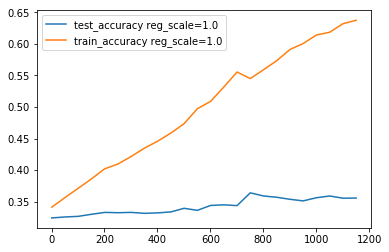

In [209]:
def neural_net_reg(x_dict, reg_scale):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg_scale, scope=None))
    layer_2 = tf.layers.dense(layer_1, n_hidden_2, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg_scale, scope=None))
    layer_3 = tf.layers.dense(layer_2, n_hidden_3, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg_scale, scope=None))
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_3, num_classes)
    return out_layer
    
def model_fn_reg(features, labels, params, mode):
    # Build the neural network
    #pass through regularization scale value to neural network constructor
    logits = neural_net_reg(features, reg_scale=params['reg_scale'])
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs


#*******************
#code from Q1
#modified to incorporate trial range of regularization scale values
#*******************


tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt

for r in [1.0]:         # regularization scale value of 1.0 was shown to perform best from [0.01, 0.1, 1.0, 10., 100.]
    max_steps = 1200
    num_log_steps = 50
    num_steps_array = list(range(1,max_steps,num_log_steps))
    test_accuracy = []
    train_accuracy = []

    #define input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Train}, y=Train_path,
    batch_size=batch_size, num_epochs=None, shuffle=True)

    #define input function for train error
    train_error_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Train}, y=Train_path,
    batch_size=batch_size, shuffle=False)

    #define input function for testing error
    test_error_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Test}, y=Test_path,
    batch_size=batch_size, shuffle=False)

    model = tf.estimator.Estimator(model_fn_reg, params={'reg_scale': r})
    
    print("Training...")
    #for num_steps in num_steps_array:
    for step_num in num_steps_array:
        print("step number:", step_num)

        #train model
        model.train(input_fn, steps=num_log_steps)

        #evaluate training accuracy
        train_accuracy.append(model.evaluate(train_error_fn)["accuracy"])

        #evaluate testing accuracy
        test_accuracy.append(model.evaluate(test_error_fn)["accuracy"])

    plt.plot(num_steps_array, test_accuracy, label = "test_accuracy reg_scale={}".format(r))
    plt.plot(num_steps_array, train_accuracy, label = "train_accuracy reg_scale={}".format(r))
    
plt.legend()
plt.show()

# -----------------------------------------------------#

In [210]:
print(test_accuracy)

[0.32425001, 0.32574999, 0.32675001, 0.33000001, 0.333, 0.33250001, 0.333, 0.33149999, 0.33225, 0.33375001, 0.33950001, 0.33625001, 0.34400001, 0.345, 0.34375, 0.36399999, 0.359, 0.35699999, 0.35374999, 0.35124999, 0.35624999, 0.359, 0.35550001, 0.35574999]


Training...
step number: 1
step number: 51
step number: 101
step number: 151
step number: 201
step number: 251
step number: 301
step number: 351
step number: 401
step number: 451
step number: 501
step number: 551
step number: 601
step number: 651
step number: 701
step number: 751
step number: 801
step number: 851
step number: 901
step number: 951
step number: 1001
step number: 1051
step number: 1101
step number: 1151


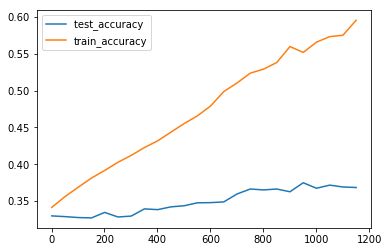

In [211]:
#------------------ Your code here -------------------#
Dropout_rate=0.1
def neural_net_reg(x_dict, reg_scale):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    layer_1 = tf.layers.dropout(layer_1,rate=Dropout_rate,noise_shape=None,seed=None,training=False,name=None)
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    layer_2 = tf.layers.dropout(layer_2,rate=Dropout_rate,noise_shape=None,seed=None,training=False,name=None)
    layer_3 = tf.layers.dense(layer_2, n_hidden_3)
    layer_3 = tf.layers.dropout(layer_2,rate=Dropout_rate,noise_shape=None,seed=None,training=False,name=None)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_3, num_classes)
    return out_layer
    
def model_fn_reg(features, labels, params, mode):
    # Build the neural network
    #pass through regularization scale value to neural network constructor
    logits = neural_net_reg(features, reg_scale=params['reg_scale'])
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs


#*******************
#code from Q1
#modified to incorporate trial range of regularization scale values
#*******************


tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt

for r in [1.0]:         # regularization scale value of 1.0 was shown to perform best from [0.01, 0.1, 1.0, 10., 100.]
    max_steps = 1200
    num_log_steps = 50
    num_steps_array = list(range(1,max_steps,num_log_steps))
    test_accuracy = []
    train_accuracy = []

    #define input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Train}, y=Train_path,
    batch_size=batch_size, num_epochs=None, shuffle=True)

    #define input function for train error
    train_error_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Train}, y=Train_path,
    batch_size=batch_size, shuffle=False)

    #define input function for testing error
    test_error_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': Test}, y=Test_path,
    batch_size=batch_size, shuffle=False)

    model = tf.estimator.Estimator(model_fn_reg, params={'reg_scale': r})
    
    print("Training...")
    #for num_steps in num_steps_array:
    for step_num in num_steps_array:
        print("step number:", step_num)

        #train model
        model.train(input_fn, steps=num_log_steps)

        #evaluate training accuracy
        train_accuracy.append(model.evaluate(train_error_fn)["accuracy"])

        #evaluate testing accuracy
        test_accuracy.append(model.evaluate(test_error_fn)["accuracy"])

    plt.plot(num_steps_array, test_accuracy, label = "test_accuracy ".format(r))
    plt.plot(num_steps_array, train_accuracy, label = "train_accuracy".format(r))
    
plt.legend()
plt.show()

# -----------------------------------------------------#

In [212]:
print(test_accuracy)

[0.33000001, 0.329, 0.32775, 0.32725, 0.33475, 0.3285, 0.32975, 0.33950001, 0.33849999, 0.34224999, 0.34375, 0.34775001, 0.34799999, 0.34900001, 0.35975, 0.36649999, 0.36524999, 0.36649999, 0.36274999, 0.375, 0.36750001, 0.37175, 0.36925, 0.36849999]
